In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from rdkit.Chem import Draw


matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 144

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "HRH1"

# Files we are processing
file_path_sdf_active = "./HRH1/docking/HRH1_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./HRH1/docking/HRH1_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./HRH1/strain/HRH1_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./HRH1/strain/HRH1_decoy_docking_lib_sorted.csv"

In [3]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [4]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [5]:
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [6]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [7]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])


In [8]:
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [9]:
pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

for df in pre_merge:
    print(df.shape)

(253, 33)
(13432, 33)
(252, 5)
(13431, 5)


In [10]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [11]:
post_merge = [active_data, decoy_data]

for df in post_merge:
    print(df.shape)

(252, 37)
(13431, 37)


In [12]:
all_data = pd.concat([active_data, decoy_data])

print(all_data.shape)

(13683, 37)


In [13]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

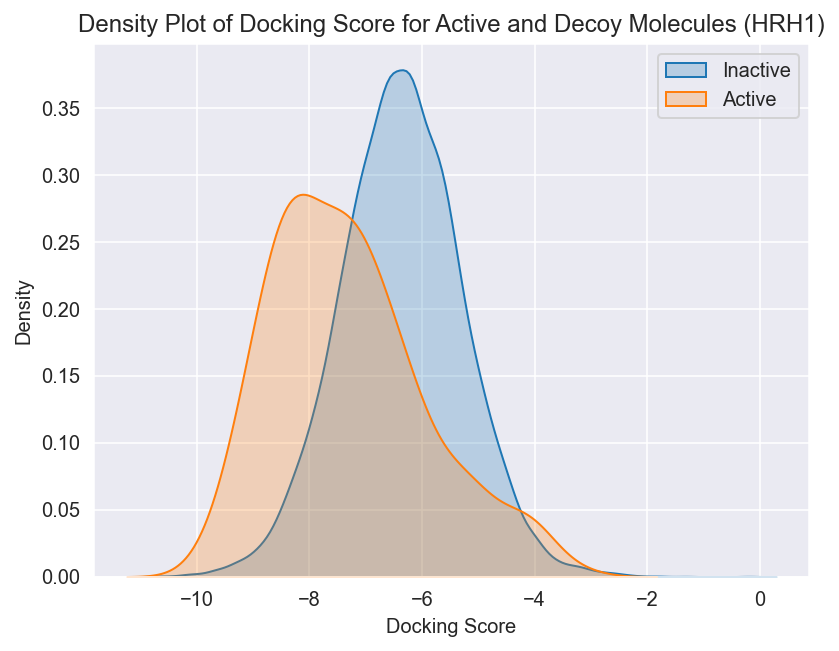

In [14]:
plot_density(all_data, title_suffix)

In [15]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order
    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [16]:
calculate_enrichment_parameters(all_data)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C64600295_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a02c9000>,0,HRH1_chembl19_set_decoy_sc.smi,15894,53161,0,S-OPLS,48.4373,1,C64600295_Isomer1-1,HRH1,15893,5,-10.703800,-0.345283,-1.08467,-2.41403,-10.7038,-4.23678,-0.36,-0,-1.8003,-39.9131,-16.4396,0.423012,-0.268111,-91.7258,-56.3527,1.46548,2,256,0,3.401582,2.939193,4.02343,4.0,0,252,0.0,0.000073
2,C39733819_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a0219930>,0,HRH1_chembl19_set_decoy_sc.smi,15298,53161,0,S-OPLS,36.4399,1,C39733819_Isomer1-1,HRH1,15297,8,-10.662000,-0.343937,-1.08044,-2.40462,-10.662,-3.87667,-0.360641,-0,-2.69907,-45.2487,-11.3564,0.553337,-0.31311,-71.4652,-56.6051,10.7609,45,203,0,11.606800,9.321827,NaN,1.0,0,252,0.0,0.000146
3,C71973072_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a02c9230>,0,HRH1_chembl19_set_decoy_sc.smi,15477,53161,0,S-OPLS,46.9796,1,C71973072_Isomer1-1,HRH1,15476,11,-10.403400,-0.29724,-0.97229,-2.28377,-10.4034,-4.37419,-0.1611,-0,-1.50889,-38.1185,-19.8717,0.919772,-0.392299,-79.1983,-57.9903,10.938,109,162,0,10.400862,9.050967,NaN,5.0,0,252,0.0,0.000219
4,C07986032_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a02c9150>,0,HRH1_chembl19_set_decoy_sc.smi,5528,53161,0,S-OPLS,36.1479,1,C07986032_Isomer1-1,HRH1,5527,8,-10.315400,-0.412616,-1.2065,-2.44506,-10.3154,-4.12142,-0.297155,-0,-2.64459,-44.344,-10.4756,0.752909,-0.216601,-91.1781,-54.8196,5.27516,146,191,0,9.139044,6.379335,NaN,5.0,0,252,0.0,0.000292
5,C63462845_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a02c90e0>,0,HRH1_chembl19_set_decoy_sc.smi,12785,53161,0,S-OPLS,37.5378,1,C63462845_Isomer1-1,HRH1,12784,3,-10.205500,-0.463886,-1.29983,-2.49459,-10.2055,-2.65358,-0.522504,-0,-2.47726,-37.6402,-18.0587,0.285694,-0.247008,-88.0166,-55.6989,5.21826,14,232,0,4.785498,3.862571,NaN,2.0,0,252,0.0,0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13679,C13942475_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b47ef610>,0,HRH1_chembl19_set_decoy_sc.smi,6379,53161,0,S-OPLS,39.5593,1,C13942475_Isomer1-1,HRH1,6378,9,-2.193890,-0.0731298,-0.227231,-0.498477,-2.19389,-2.24714,0,-0,-0.065268,-9.18217,-0.309056,0.663137,-0.0391523,-10.0921,-9.49123,14.3713,6,180,0,-1.000000,0.000000,0.00000,4.0,252,252,1.0,0.999708
13680,C01774943_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b47ef680>,0,HRH1_chembl19_set_decoy_sc.smi,9899,53161,0,S-OPLS,38.7671,1,C01774943_Isomer1-1,HRH1,9898,10,-1.866300,-0.0602033,-0.189121,-0.420908,-1.8663,-1.45901,-0.32,-0,1.34394,-28.2339,-1.3894,0.714952,-0.526084,-22.4301,-29.6233,15.4063,5,59,0,13.056891,9.459337,NaN,2.0,252,252,1.0,0.999781
13681,C36834597_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b47ef6f0>,0,HRH1_chembl19_set_decoy_sc.smi,15188,53161,0,S-OPLS,37.5533,1,C36834597_Isomer1-1,HRH1,15187,10,-1.777260,-0.0538564,-0.172746,-0.395254,-1.77726,-2.21433,0,-0,0.528321,-31.6202,6.89076,0.753132,-0.296987,-21.081,-24.7295,13.2626,27,3,0,9.564842,8.365975,NaN,4.0,252,252,1.0,0.999854
13682,C63802120_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b47ef7d0>,0,HRH1_chembl19_set_decoy_sc.smi,2509,53161,0,S-OPLS,29.474,1,C63802120_Isomer1-1,HRH1,2508,12,-1.315470,-0.0469812,-0.142663,-0.30365,-1.31547,-1.59429,0,-0,-0.164838,-13

In [17]:
def plot_enrichment_curve(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"],
        label="Enrichment AUC = {:.2f}".format(enrichment_auc),
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Fraction of Identified Actives")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()

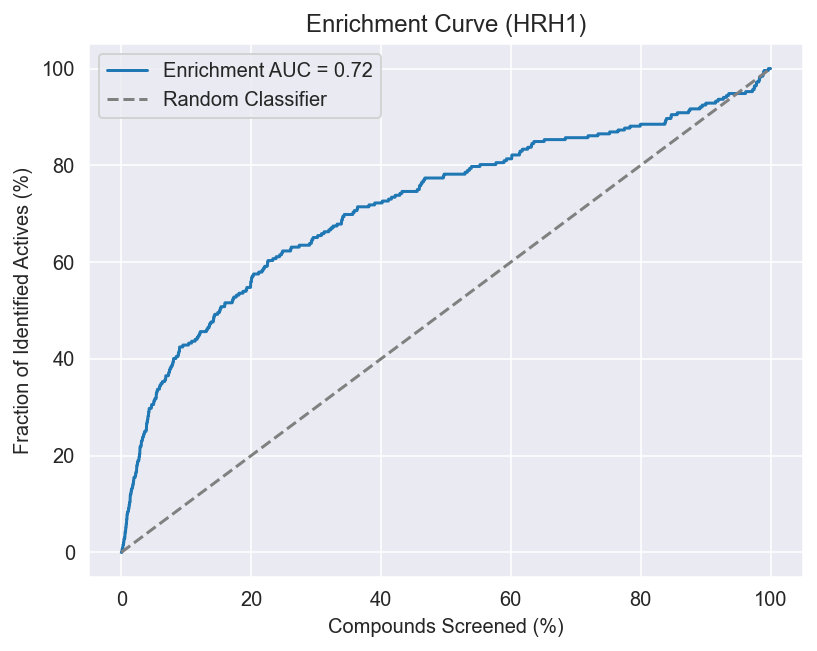

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc


def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}".format(enrichment_auc),
    )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Fraction of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()

plot_enrichment_curve_classifier(all_data, title_suffix)

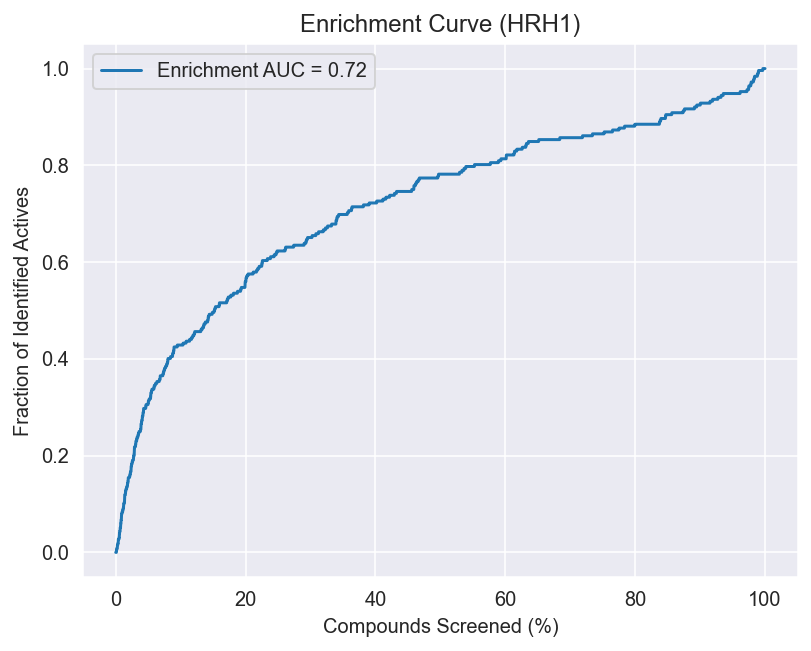

In [19]:
plot_enrichment_curve(all_data, title_suffix)

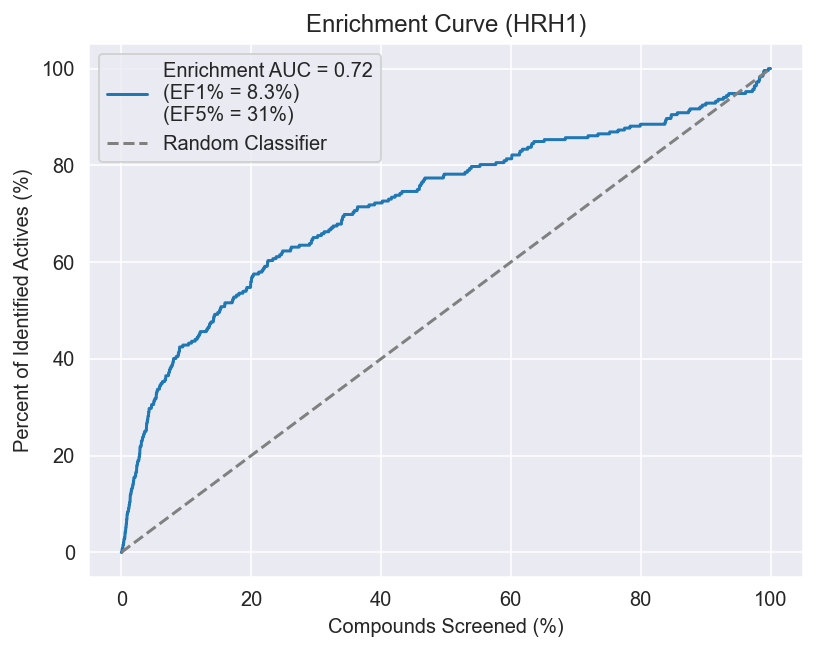

In [20]:
def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Calculate the enrichment at the closest value to 1%
    # Subtract 0.01 (1%) from the 'Percentage_Screened' column and find the absolute value
    # (df['Percentage_Screened'] - 0.01).abs()
    # Sort the resulting series and take the first index (smallest difference)
    # (df['Percentage_Screened'] - 0.01).abs().argsort()[:1]
    # Use the index to get the row from the dataframe
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    )

    hitrate_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent.index.values[0]
    )

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_five_percent = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    )

    hitrate_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent.index.values[0]
    )
    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            enrichment_auc, enrichment_at_one_percent * 100, enrichment_at_five_percent * 100 
        ),
    )

    #   # Plot the enrichment at 1%
    #   plt.scatter(
    #   1,
    #   enrichment_at_one_percent * 100,
    #   s=0,
    #   color='black',
    #   label="Enrichment (%) at 1% = {:.2f}".format(enrichment_at_one_percent*100),
    # )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Percent of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()


plot_enrichment_curve_classifier(all_data, title_suffix)

In [21]:
def plot_roc_curve_inverted(y_true, y_scores, title_suffix):
  """
  Plot the ROC curve for the given true labels and inverted scores.

  :param y_true: The true binary labels.
  :param y_scores: The predicted scores where lower scores indicate positive class.
  :param title_suffix: The suffix to add to the title of the plot.
  """
  # Inverting the scores
  y_scores_inverted = -y_scores

  # Compute the ROC curve and AUC with inverted scores
  fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")
  plt.legend(loc="best")
  plt.show()

In [22]:
def plot_roc_curve_inverted(y_true, y_scores, title_suffix):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param y_true: The true binary labels.
    :param y_scores: The predicted scores where lower scores indicate positive class.
    :param title_suffix: The suffix to add to the title of the plot.
    """
    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")
    plt.legend(loc="best")
    plt.show()

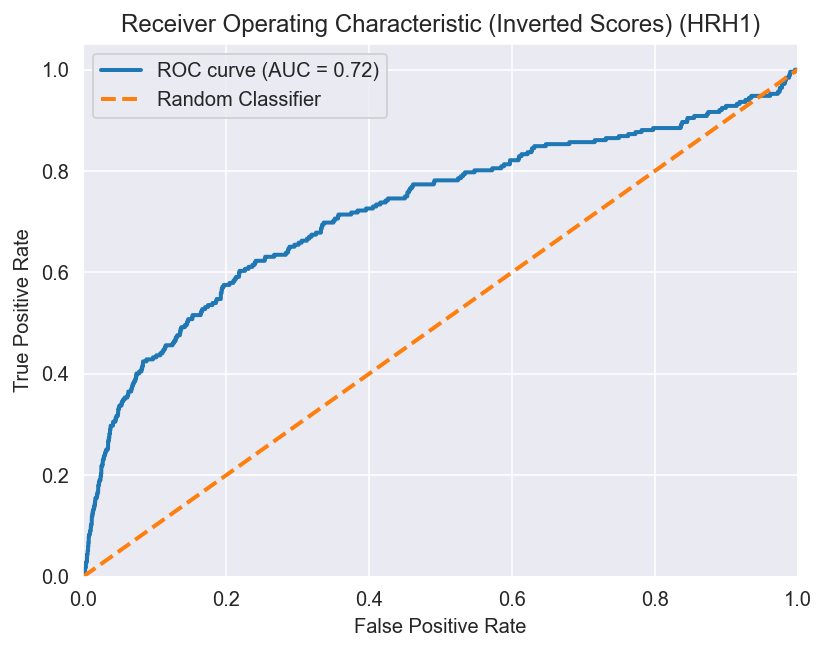

In [23]:
plot_roc_curve_inverted(all_data["Activity"],all_data["r_i_docking_score"], title_suffix)

AUC for the original ROC curve: 0.5
AUC for the log-transformed ROC curve: 0.9982936817079362
Range of Log FPR: -6.907755278982137 to 0.0009995003330834232
LogAUC for the log-transformed ROC curve: 0.14451781242821266


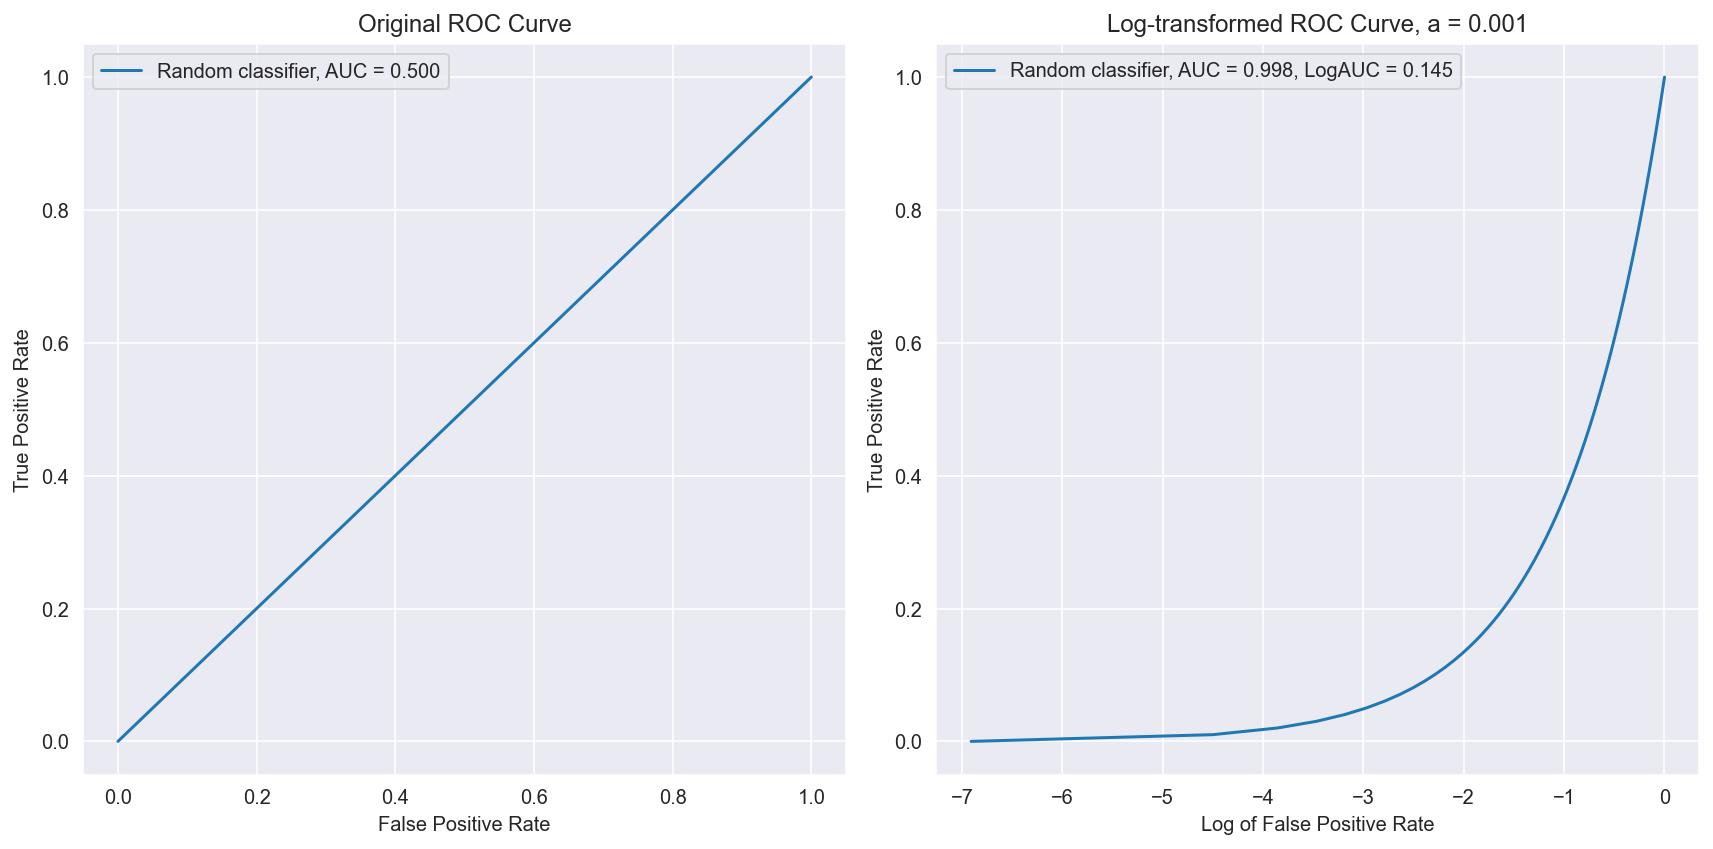

In [24]:
# Define the points
x_values_random_class = np.linspace(0, 1, 100)
y_values_random_class = x_values_random_class  # For a random classifier, the true positive rate equals the false positive rate

# Define a small constant
a = 1e-3

# Apply a logarithmic transformation to the x values
x_values_log = np.log(x_values_random_class + a)

# Calculate the AUC for the original ROC curve
auc_original = auc(x_values_random_class, y_values_random_class)
print(f"AUC for the original ROC curve: {auc_original}")

# Calculate the AUC for the log-transformed ROC curve
auc_transformed = auc(x_values_log, y_values_random_class)
print(f"AUC for the log-transformed ROC curve: {auc_transformed}")
print(f"Range of Log FPR: {np.min(x_values_log)} to {np.max(x_values_log)}")

# Calculate the LogAUC for the log-transformed ROC curve
log_auc_transformed = auc_transformed / -np.log(a)
print(f"LogAUC for the log-transformed ROC curve: {log_auc_transformed}")

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original ROC curve on the first subplot
axs[0].plot(
    x_values_random_class,
    y_values_random_class,
    label=f"Random classifier, AUC = {auc_original:.3f}",
)
axs[0].set_title("Original ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="best")
axs[0].grid(True)

# Plot the transformed ROC curve on the second subplot
axs[1].plot(
    x_values_log,
    y_values_random_class,
    label=f"Random classifier, AUC = {auc_transformed:.3f}, LogAUC = {log_auc_transformed:.3f}",
)
axs[1].set_title(f"Log-transformed ROC Curve, a = {a}")
axs[1].set_xlabel("Log of False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="best")
axs[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
def plot_linlog10_roc_curve(df, title_suffix, a=1e-3):
  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate the AUC for the valid range
  linlog_auc = auc(log_fpr_valid, tpr_valid)
  log_auc = linlog_auc / -np.log10(a)

  # Plot the ROC curve
  plt.plot(
    log_fpr_valid,
    tpr_valid,
    color="blue",
    label=f"ROC Curve ({title_suffix}), LogAUC = {log_auc:.3f}, a = {a}",
  )

  # Define the points for the random classifier
  x_values_random_class = np.linspace(a, 1, 100)
  y_values_random_class = x_values_random_class  # For a random classifier, the true positive rate equals the false positive rate

  # Apply a logarithmic transformation to the x values
  x_values_log = np.log10(x_values_random_class)

  # Calculate the AUC for the random classifier
  linlog_auc_random = auc(x_values_log, y_values_random_class)
  log_auc_random = linlog_auc_random / -np.log10(a)

  # Plot the ROC curve for the random classifier
  plt.plot(
    x_values_log,
    y_values_random_class,
    color="red",
    linestyle="--",
    label=f"Random Classifier, LogAUC = {log_auc_random:.3f}, a = {a}",
  )

  plt.xlim([np.log10(a), 0])
  plt.ylim([0, 1])
  plt.xlabel("Log (False Positive Rate)")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="upper left")
  plt.title(f"Linear Log10 ROC Curve ({title_suffix})")
  plt.show()

  # print(
  #   f"Range of integration in linlog_auc: {log_fpr_valid[0]} to {log_fpr_valid[-1]}"
  # )
  # print(f"Value of linglog_auc: {linlog_auc}")
  # print(f"Value of log_auc: {log_auc}")
  # print(f"Value of linglog_auc for random classifier: {linlog_auc_random}")
  # print(f"Value of log_auc for random classifier: {log_auc_random}")

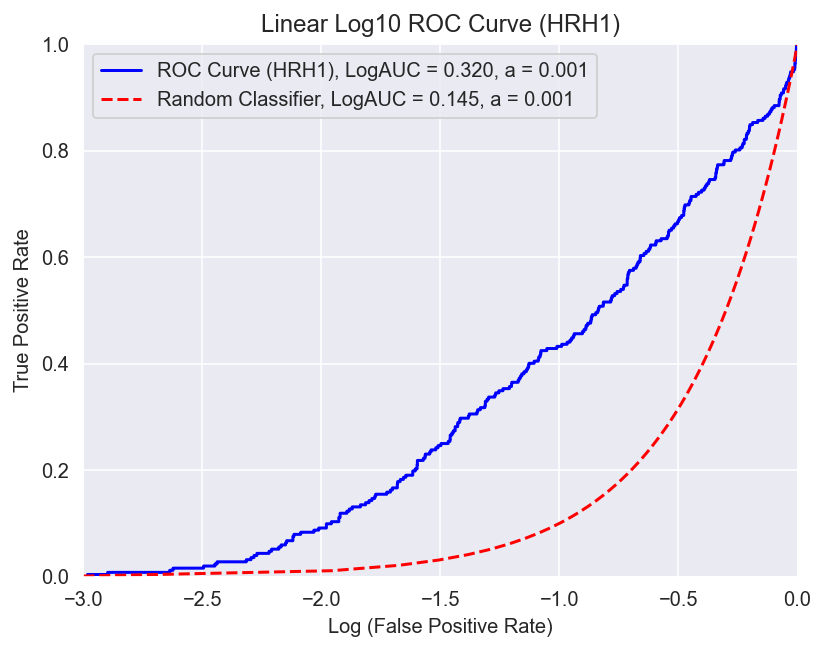

In [26]:
plot_linlog10_roc_curve(all_data, title_suffix)

Now we need to evaluate the impact of strain filtering. We will set thresholds to cut off the data like their paper did. Then, we will plot both the change in performance by logAUC, and then the Linear LogAUC for the thresholds.

In [27]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [28]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [29]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

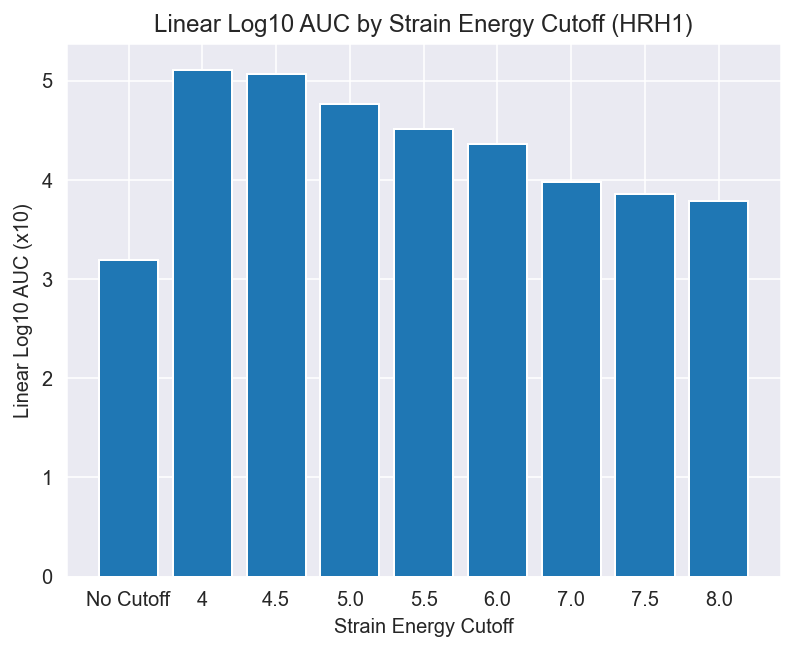

In [30]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

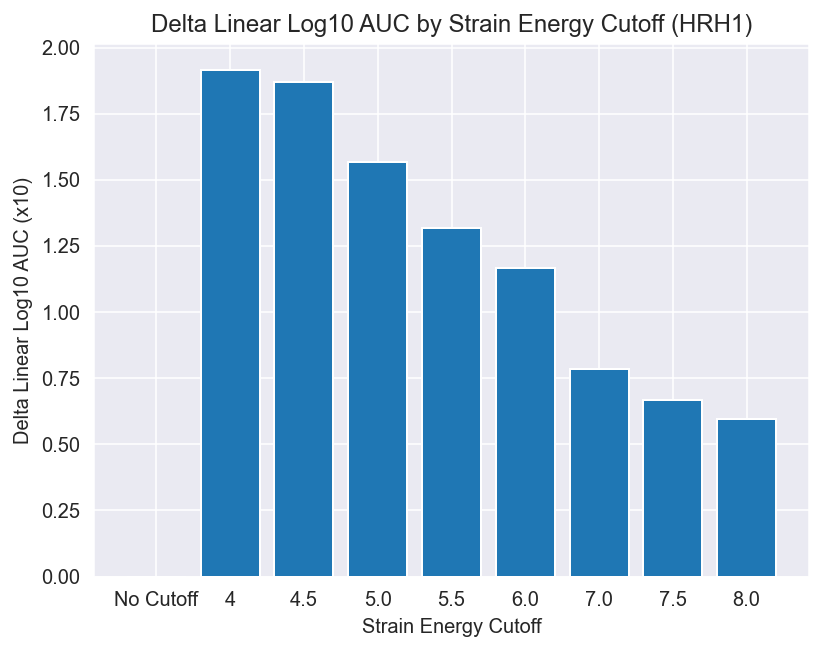

In [31]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [32]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [33]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds))

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=cmap(i))

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

In [34]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_83846/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


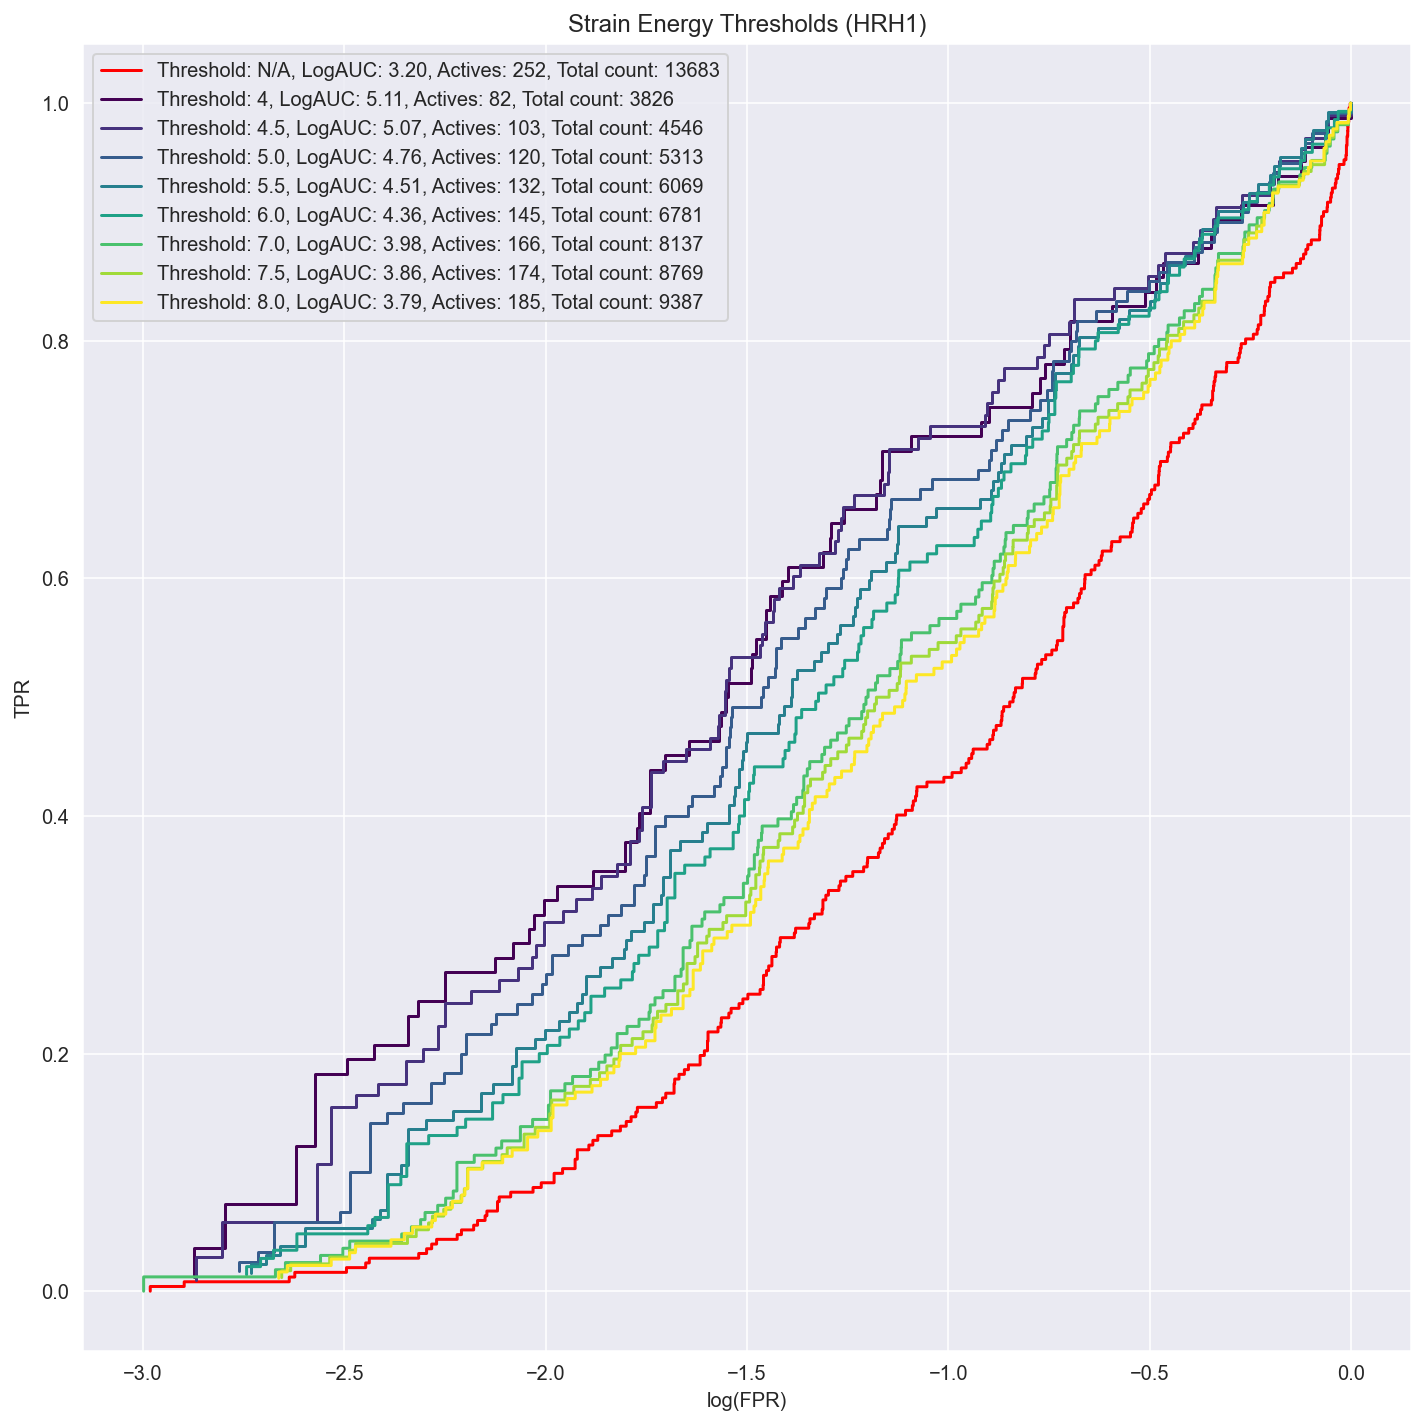

In [35]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)